In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow import keras
from data_preprocess import Preprocessor
plt.rcParams.update({'axes.labelsize': 14})
plt.rcParams.update({'axes.titlesize': 14})
plt.rcParams.update({'xtick.labelsize': 14})
plt.rcParams.update({'ytick.labelsize': 14})

In [458]:
# Load the data and the model
df_0 = pd.read_csv("data/final/1936/faulty/FaultyMotor1_1936_30.csv", header=None)
model = keras.models.load_model('models/Non-Mapping ML Model #10')

In [459]:
# data, channels, sr, hz, type
# Edit the channels, hz, and type for each dataset
# channels: is given as a tuple of the channels to be used
# sr: the sampling rate of the data
# hz: the frequency of the data, given as a tuple (only one value if the hz is the same for all channels)
# type: the type of the data, given as a string of n, f, or i for each channel. f is Faulty, n is Normal, and i is Imbalanced)
data_df = [
    [df_0, (0, 1, 2, 3), 20000, (60,), "nnnn"]
]

In [461]:
# The Preprocessor class is used to preprocess the data
# max_freq: The maximum frequency to keep in the data
# kaiser_beta: The beta value for the kaiser window
# zero_freqs: The frequencies to zero out in the data (Used for testing which frequencies are important)
# compute_preprocess: Preprocesses the data and returns the preprocessed data
data_interval = 3
preprocessor = Preprocessor(max_freq=500, kaiser_beta=10, zero_freqs=[])

# If channels are kept separate, the data will be returned as a list of arrays where each array is a channel in a dataset.
# Each array will contain the FFT data for each interval in the channel.

# If channels are not kept separate, the data will be returned as a single array where each row is an interval in the dataset.

# If shuffle is set to True, the data will be shuffled before being returned (Useful for shuffling training data)
# If shuffle is set to False, the data will not be shuffled before being returned (Useful for testing data)

test_df = preprocessor.compute_preprocess(data_df, data_interval, shuffle=False, keep_channels_separate=True)

In [489]:
def get_only_drive_freq(X, hz):
    X_return = []
    for i in range(len(X)):
        temp = X[i]
        hz_temp = hz[i]
        to_add = []
        freq_spectrum = np.linspace(0, 200, len(temp))

        start = np.where(freq_spectrum >= (hz_temp - 10))[0][0]
        end = np.where(freq_spectrum <= (hz_temp + 10))[0][-1]
        to_add = np.append(to_add, temp[start:end+1])

        start = np.where(freq_spectrum >= (hz_temp*2 - 10))[0][0]
        end = np.where(freq_spectrum <= (hz_temp*2 + 10))[0][-1]
        to_add = np.append(to_add, temp[start:end+1])

        X_return.append(to_add)
    X_return = np.array(X_return)
    return X_return

In [490]:
averages = []
for i, channel in enumerate(test_df):
    # for each channel, separate the x, y, and hz data
    hz = channel[:, -2]
    X  = channel[:, :-2]
    y  = channel[:, -1]
    # For models that use only the drive freqency and the first harmonic, use the following line
    # X = get_only_drive_freq(X, hz)
    print(X.shape, y.shape, hz.shape)
    # For models that don't have the hz data, only passs X like model.predict(X)
    z = model.predict([X, hz])
    z = np.mean(z, axis=0)
    z = [round(x, 2) for x in z]
    averages.append(z)
averages = np.array(averages)

(403, 1501) (403,) (403,)
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
(403, 1501) (403,) (403,)
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
(403, 1501) (403,) (403,)
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
(403, 1501) (403,) (403,)
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


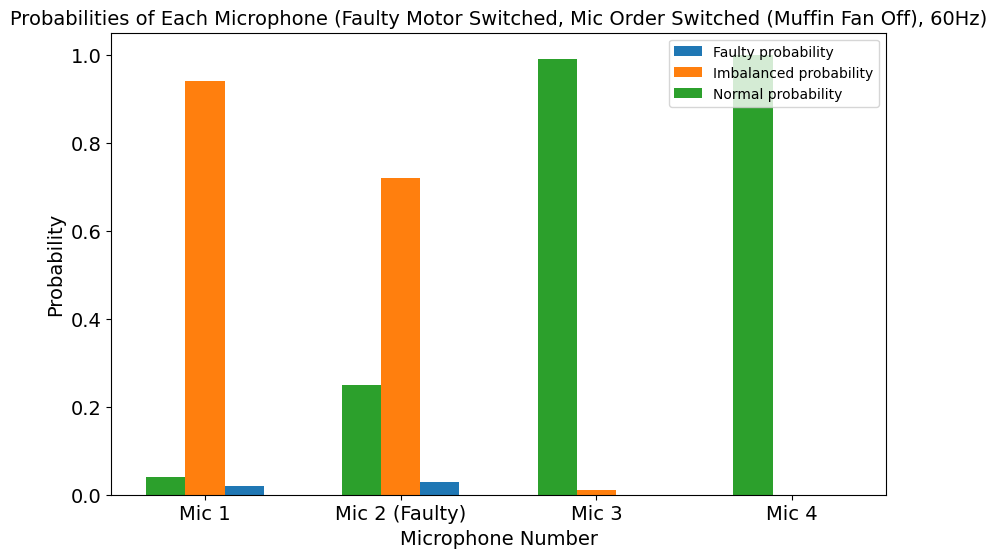

In [491]:
mics = []
# Change the impacted motor and impact type here
impacted_motor = 2
impact_type = "Faulty"
include_impacted = True
for i in range (len(averages)):
    if (i+1) == impacted_motor:
        mics.append(f'Mic {i+1} {f'({impact_type})' if include_impacted else ""}')
    else:
        mics.append(f'Mic {i+1}')
x_axis = np.arange(len(averages))
plt.figure(figsize=(10, 6))
plt.bar(x_axis+0.2, averages[:, 2], 0.2, label="Faulty probability")
plt.bar(x_axis, averages[:, 1], 0.2, label="Imbalanced probability")
plt.bar(x_axis-0.2, averages[:, 0], 0.2, label="Normal probability")
plt.xlabel("Microphone Number")
plt.ylabel("Probability")
plt.title(f'Probabilities of Each Microphone (Faulty Motor Switched, Mic Order Switched (Muffin Fan Off), {data_df[0][3][0]}Hz)')
plt.xticks(x_axis, mics)
plt.ylim(0, 1.05)
plt.legend()
plt.show()
